### Multi-Armed Bandit Approach to A | B Testing
*Bayesian Bandits*.

1. Sample a random variable $X_b$ from the prior of bandit $b$, for all $b$.
2. Select the bandit with largest sample, i.e. select $B = \text{argmax}\;\; X_b$.
3. Observe the result of pulling bandit $B$, and update your prior on bandit $B$.
4. Return to 1.

Algorithm samples from $N$ distributions. Since the initial priors are $\text{Beta}(\alpha=1,\beta=1)$ (a uniform distribution), and the observed result $X$ (a win or loss, encoded 1 and 0) is Binomial, the posterior is a $\text{Beta}(\alpha=1+X,\beta=1+1−X)$.

Algorithm doesn't discard losers, but picks them at a decreasing rate (set by learningRate) as we gather confidence that there exist *better* bandits. There is always a non-zero chance that a loser will achieve the status of $B$, but the probability decreases with the number of rounds.

In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
np.seterr(invalid='ignore');

In [2]:
# Load the bandit class and engine and multile Strategies.

%run ./BanditClasses.ipynb
%run ./BanditStrategies.ipynb

Visualize the learning of the Bayesian Bandit solution.

In [3]:
figsize(14.0, 10)

beta = stats.beta
x = np.linspace(0,1,200)

def plotPriors(strategy, prob, lw = 3, alpha = 0.2, plt_vlines = True):
    ## plotting function
    wins = strategy.wins
    trials = strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1+wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw = lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x,y.pdf(x),0, color = c, alpha = alpha, 
                         label="underlying probability: %.2f" % prob[i])
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]) ,
                       colors = c, linestyles = "--", lw = 2)
        plt.autoscale(tight = "True")
        plt.title("Posteriors After %d pull" % strategy.N +\
                    "s"*(strategy.N > 1))
        plt.autoscale(tight=True)
    return

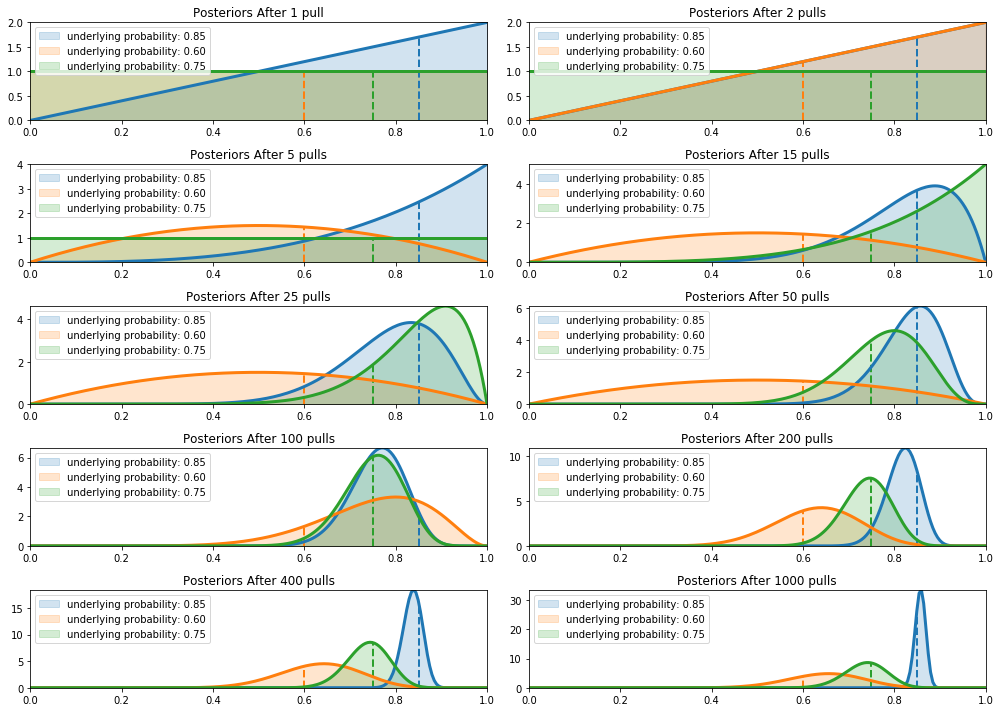

In [4]:
hiddenProbabilities = np.array([0.85, 0.60, 0.75])
bandits = Bandits(hiddenProbabilities)
bayesianStrat = BanditEngine(bandits, BayesianBandit)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]

for j,i in enumerate(draw_samples):
    plt.subplot(5, 2, j+1) 
    bayesianStrat.sample_bandits(i)
    plotPriors(bayesianStrat, hiddenProbabilities)
    plt.legend()
    plt.autoscale(tight = True)
plt.tight_layout()

### Loss Function

*Total regret* of a strategy, defined:

\begin{align}
R_T & = \sum_{i=1}^{T} \left( w_{opt} - w_{B(i)} \right)\\\\
& = Tw^* - \sum_{i=1}^{T} \;  w_{B(i)} 
\end{align}


where $w_{B(i)}$ is the probability of a prize of the chosen bandit in the $i$ round. A total regret of 0 means the strategy is matching the best possible score. This is likely not possible, as initially our algorithm will often make the wrong choice.  Ideally, a strategy's total regret should flatten as it learns the best bandit. (Mathematically, we achieve $w_{B(i)}=w_{opt}$ often)


Plot the total regret of this simulation, including the scores of some other strategies:

1. Bayesian Bandit strategy from above
2. Largest Bayesian Upper Credible Bound: pick the bandit with the largest upper bound in its 95% credible region. 
3. Largest Bayesian Lower Credible Bound: pick the bandit with the largest lower bound in its 95% credible region.
4. Bayes-UCB algorithm: pick the bandit with the largest *score*, where score is a dynamic quantile of the posterior.
5. Max Mean of posterior: choose the bandit with the largest posterior mean. 
6. Random: randomly choose a bandit to pull.

In [5]:
# Define problem
hiddenProbabilities = np.array([0.15, 0.2, 0.1, 0.05])
bandits = Bandits(hiddenProbabilities)

# Loss Function
def regret(probabilities, choices):
    w_opt = probabilities.max()
    return (w_opt - probabilities[choices.astype(int)]).cumsum()

# Chose strategies for engine to compare results
strategies= [BayesianBandit,
            upperCredible,
            lowerCredible,
            BayesUCB, 
            maxMean,
            random]

# Set learning rate
# If rate < 1, the algorithm will forget its previous wins quicker.
# If Rate > 1 algorithm will choose earlier winners more often.
learningRate = 1

algos = []
for strat in strategies:
    algos.append(BanditEngine(bandits, strat, learningRate))

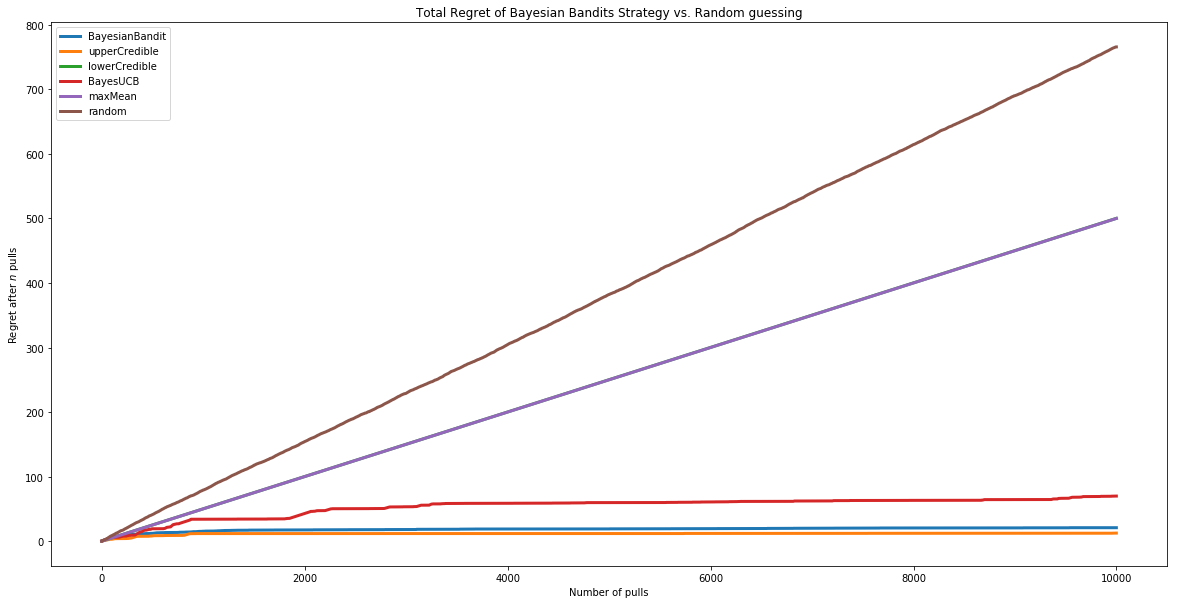

In [6]:
figsize(20, 10)

# Train 10000 times
for strat in algos:
    strat.sample_bandits(10000)    
    
# Test and plot
for i,strat in enumerate(algos):
    _regret = regret(hiddenProbabilities, strat.choices)
    plt.plot(_regret, label = strategies[i].__name__, lw = 3)

plt.title("Total Regret of Bayesian Bandits Strategy vs. Random guessing")
plt.xlabel("Number of pulls")
plt.ylabel("Regret after $n$ pulls");
plt.legend(loc = "upper left");

Define *expected total regret*:

$$\bar{R}_T = E[ R_T ] $$

It can be shown that any *sub-optimal* strategy's expected total regret is bounded below logarithmically.

$$ E[R_T] = \Omega \left( \;\log(T)\; \right) $$

Any strategy that matches logarithmic-growing regret is said to "solve" the Multi-Armed Bandit problem.

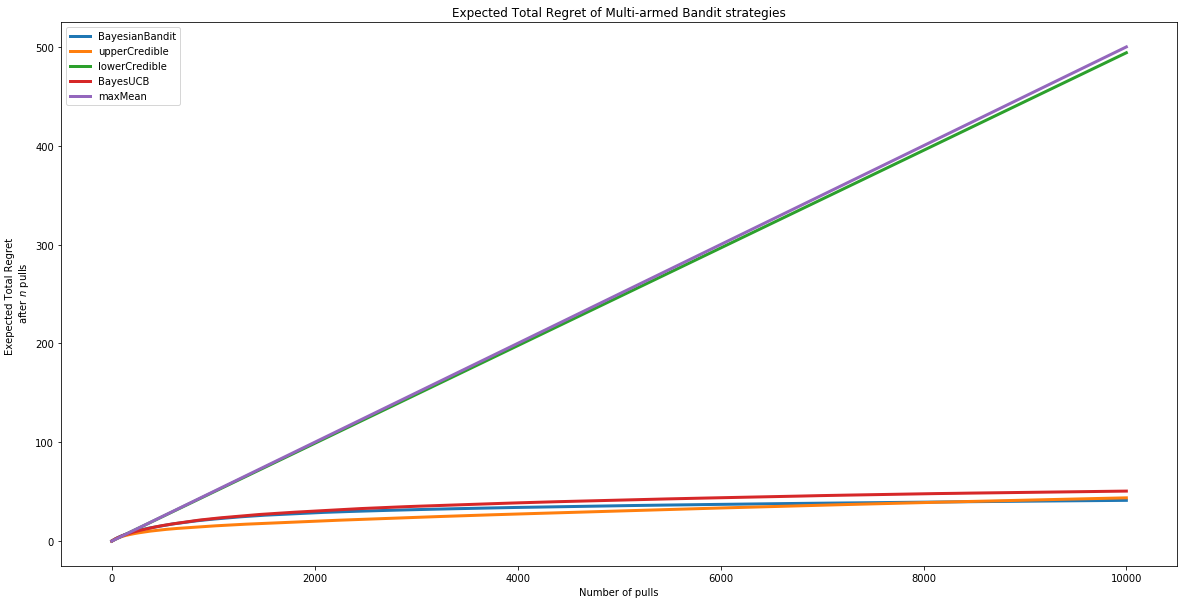

In [7]:
trials = 500
expected_total_regret = np.zeros((10000, 6))

for i_strat, strat in enumerate(strategies[:-1]):
    for i in range(trials):
        general_strat = BanditEngine(bandits, strat)
        general_strat.sample_bandits(10000)
        _regret =  regret(hiddenProbabilities, general_strat.choices)
        expected_total_regret[:,i_strat] += _regret
    plt.plot(expected_total_regret[:,i_strat] / trials, lw =3, label = strat.__name__)
        
plt.title("Expected Total Regret of Multi-armed Bandit strategies")
plt.xlabel("Number of pulls")
plt.ylabel("Exepected Total Regret \n after $n$ pulls");
plt.legend(loc = "upper left");

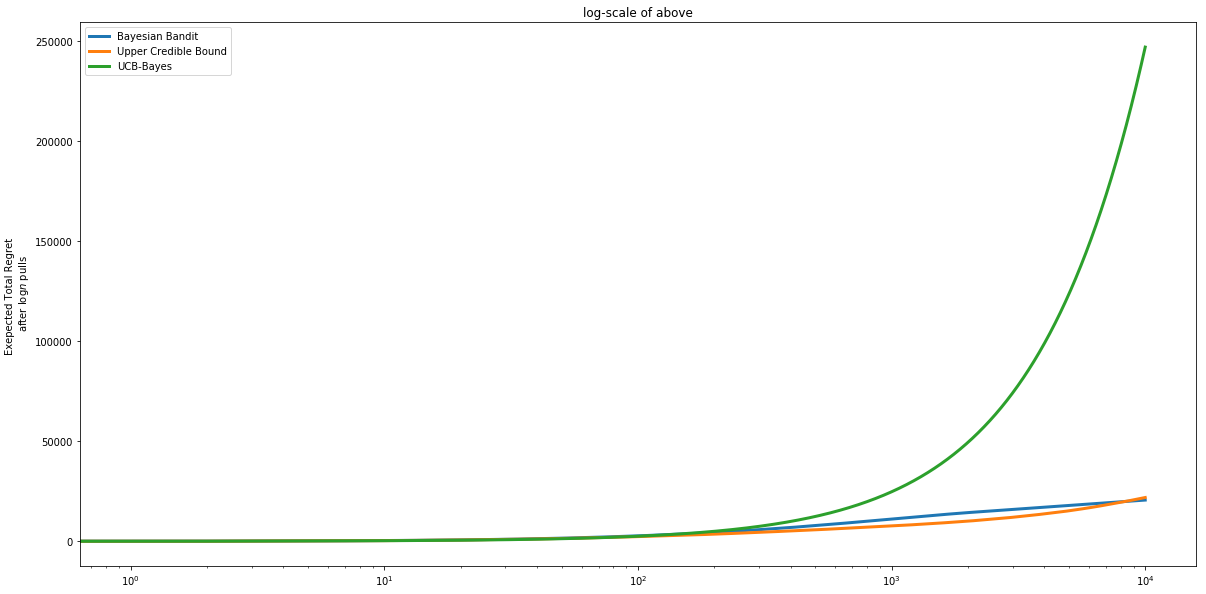

In [8]:
figsize(20, 10)

plt.figure()
[pl1, pl2, pl3] = plt.plot(expected_total_regret[:, [0,1,2]], lw = 3)
plt.xscale("log")
#plt.legend(loc = "upper left");
plt.legend([pl1, pl2, pl3], 
           ["Bayesian Bandit", "Upper Credible Bound", "UCB-Bayes"],
            loc="upper left")

plt.ylabel("Exepected Total Regret \n after $\log{n}$ pulls");
plt.title( "log-scale of above" );
plt.ylabel("Exepected Total Regret \n after $\log{n}$ pulls");

Run Baysian bandit algorithm with 35 bandits with probabilities randomly generated and beta priors

[0.1598609  0.03401202 0.00294629 0.02401872 0.00925203 0.17662201
 0.0295472  0.24387061 0.03601882 0.0901137  0.05963915 0.11777358
 0.00766498 0.00106974 0.03210445 0.01787709 0.094224   0.05781001
 0.03521473 0.15980088 0.01619946 0.04627932 0.00468372 0.05486251
 0.00755176 0.06725554 0.12525625 0.01546447 0.17502157 0.08531272
 0.03745995 0.0573628  0.03666133 0.1609957  0.0277482 ]


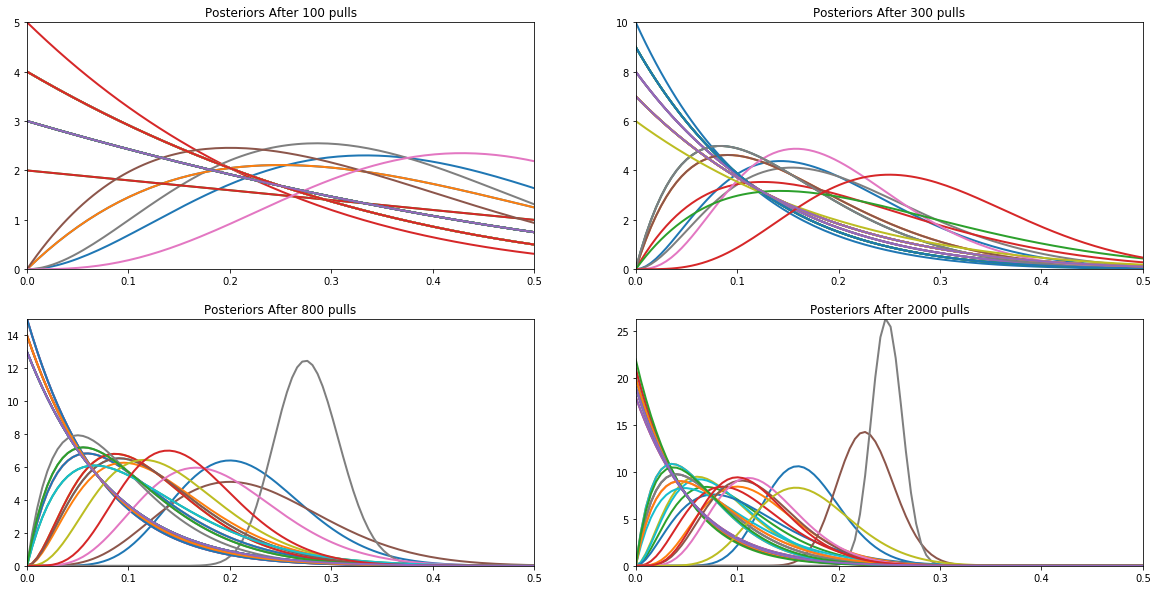

In [10]:
figsize(20, 10)
beta = stats.beta
hiddenProbabilities = beta.rvs(1,13, size = 35)
print(hiddenProbabilities)
bandits = Bandits(hiddenProbabilities)
bayesian_strat = BanditEngine(bandits, BayesianBandit)

for j,i in enumerate([100, 200, 500, 1200]):
    plt.subplot(2, 2, j+1) 
    bayesian_strat.sample_bandits(i)
    plotPriors(bayesian_strat, hiddenProbabilities, lw = 2, alpha = 0.0, plt_vlines=False)
    #plt.legend()
    plt.xlim(0, 0.5)